<a href="https://colab.research.google.com/github/snoopies/EEGTest/blob/main/bcieeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **获取数据并解压**

In [1]:
!wget https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A02T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A03T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A04T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A05T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A06T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A07T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A08T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A09T.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A01E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A02E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A03E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A04E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A05E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A06E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A07E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A08E.mat
!wget https://bnci-horizon-2020.eu/database/data-sets/001-2014/A09E.mat
!unzip -q BCICIV_2a_gdf.zip
!rm BCICIV_2a_gdf.zip

--2025-11-05 08:03:52--  https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip
Resolving www.bbci.de (www.bbci.de)... 141.23.71.83
Connecting to www.bbci.de (www.bbci.de)|141.23.71.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439968864 (420M) [application/zip]
Saving to: ‘BCICIV_2a_gdf.zip’

BCICIV_2a_gdf.zip   100%[===================>] 419.59M  1.40MB/s    in 1m 45s  

2025-11-05 08:05:37 (4.01 MB/s) - ‘BCICIV_2a_gdf.zip’ saved [439968864/439968864]

--2025-11-05 08:05:38--  https://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.205.222, 2a03:f80:ad15:91:227:205:222:1
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.205.222|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/001-2014/A01T.mat [following]
--2025-11-05 08:05:38--  https://lampx.tugraz.at/~bci/database/001-2014/A01T

# **安装python依赖**

In [2]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.9 MB/s eta 0:00:00


# **model.py**

In [3]:
# 导入必要的库
import torch
from torch import nn
from torchsummary import summary


# 按照论文创建EEGNet
class EEGNet(nn.Module):
    def __init__(self, n_classes=4, channels=22, samples=1000,
                 dropout_rate=0.5, kernel_length1=64, kernel_length2=16,
                 f1=8, d=2, f2=16):
        super(EEGNet, self).__init__()
        self.f1 = f1
        self.f2 = f2
        self.d = d
        self.samples = samples
        self.n_classes = n_classes
        self.channels = channels
        self.kernel_length1 = kernel_length1
        self.kernel_length2 = kernel_length2
        self.dropout_rate = dropout_rate

        block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=self.f1,
                kernel_size=(1, self.kernel_length1),
                stride=1,
                padding=(0, self.kernel_length1//2),
                bias=False
            ),
            nn.BatchNorm2d(num_features=self.f1)
        )

        block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=self.f1,
                out_channels=self.f1*self.d,
                kernel_size=(self.channels, 1),
                groups=self.f1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=self.f1*self.d),
            nn.ELU(),
            nn.AvgPool2d(
                kernel_size=(1, 4),
                stride=4
            ),
            nn.Dropout(p=self.dropout_rate)
        )

        block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=self.f2,
                out_channels=self.f2,
                kernel_size=(1, self.kernel_length2),
                stride=1,
                padding=(0, self.kernel_length2//2),
                groups=self.f1*self.d,
                bias=False
            ),
            nn.Conv2d(
                in_channels=self.f1*self.d,
                out_channels=self.f2,
                kernel_size=(1, 1),
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=self.f2),
            nn.ELU(),
            nn.AvgPool2d(
                kernel_size=(1, 8),
                stride=8
            ),
            nn.Dropout(p=self.dropout_rate)
        )

        self.EEGNetLayer = nn.Sequential(block1, block2, block3)

        self.ClassifierBlock = nn.Sequential(
            nn.Linear(
                in_features=self.f2*round(round(self.samples//4)//8),
                out_features=self.n_classes,
                bias=False
            ),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        if len(x.shape) != 4:
            x = torch.unsqueeze(x, dim=1)
        x = self.EEGNetLayer(x)
        x = x.view(x.size()[0], -1)
        x = self.ClassifierBlock(x)

        return x


# 模型结构可视化
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EEGNet().to(device)
    print(summary(model, input_size=(1, 22, 1000)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 22, 1001]             512
       BatchNorm2d-2          [-1, 8, 22, 1001]              16
            Conv2d-3          [-1, 16, 1, 1001]             352
       BatchNorm2d-4          [-1, 16, 1, 1001]              32
               ELU-5          [-1, 16, 1, 1001]               0
         AvgPool2d-6           [-1, 16, 1, 250]               0
           Dropout-7           [-1, 16, 1, 250]               0
            Conv2d-8           [-1, 16, 1, 251]             256
            Conv2d-9           [-1, 16, 1, 251]             256
      BatchNorm2d-10           [-1, 16, 1, 251]              32
              ELU-11           [-1, 16, 1, 251]               0
        AvgPool2d-12            [-1, 16, 1, 31]               0
          Dropout-13            [-1, 16, 1, 31]               0
           Linear-14                   

# **model_train.py**

Not setting metadata
288 matching events found
No baseline correction applied
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
MAT file keys for A01T: ['__header__', '__version__', '__globals__', 'data']
Data structure shape: (1, 9)
Trial 1: 无标签
Trial 2: 无标签
Trial 3: 无标签
Trial 4: 标签数量 48
Trial 5: 标签数量 48
Trial 6: 标签数量 48
Trial 7: 标签数量 48
Trial 8: 标签数量 48
Trial 9: 标签数量 48
提取的总标签数量: 288, 唯一标签: [1 2 3 4]
类别对应关系:
  标签 1: left hand
  标签 2: right hand
  标签 3: feet
  标签 4: tongue
最终标签形状: (288,), 唯一标签: [1 2 3 4]
Not setting metadata
288 matching events found
No baseline correction applied
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
MAT file keys for A02T: ['__header__', '__version__', '__globals__', 'data']
Data structure shape: (1, 9)
Trial 1: 无标签
Trial 2: 无标签
Trial 3: 无标签
Trial 4: 标签数量 48
Trial 5: 标签数量 48
Trial 6: 标签数量 48
Trial 7: 标签数量 48
Trial 8: 标签数量 48
Trial 9: 标签数量 48
提取的总标签数量: 288,

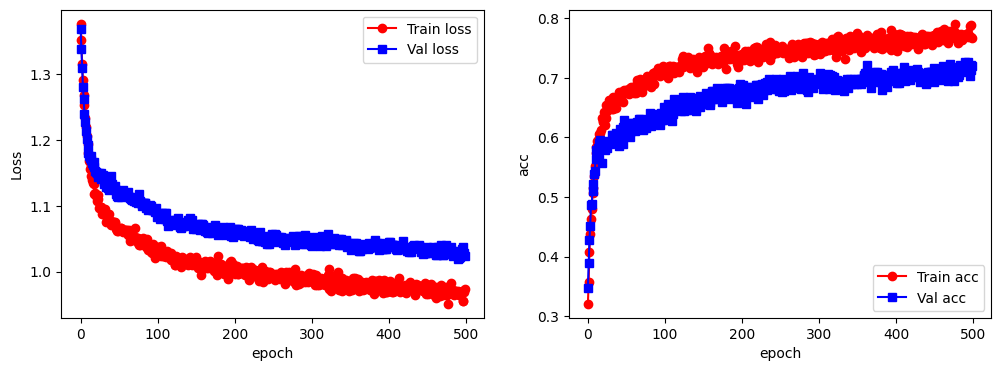

In [4]:
# 导入必要的库
import mne
import scipy
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
import time
#from model import EEGNet
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt


# 1、创建必要的本地目录，用于保存数据
if not os.path.exists('2a_train_pre'):
    os.makedirs('2a_train_pre')

# 2、原始数据读取和通道重命名
data_path = ['A0'+str(i)+'T' for i in range(1, 10)]
raw = [mne.io.read_raw_gdf(input_fname='./'+path+'.gdf',
                           stim_channel="auto",
                           preload=True,
                           verbose="error") for path in data_path]

for i in range(len(raw)):
    raw[i].rename_channels({'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2': 'FCz', 'EEG-3': 'FC2',
                            'EEG-4': 'FC4', 'EEG-5': 'C5', 'EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz',
                            'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6', 'EEG-9': 'CP3', 'EEG-10': 'CP1',
                            'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4', 'EEG-14': 'P1', 'EEG-15': 'Pz',
                            'EEG-16': 'P2', 'EEG-Pz': 'POz'})

# 3、提取MI时间，完成坏值清洗，并封装
events = []
event_ids = []
for i in range(len(raw)):
    event_to_id = dict({'769': 7, '770': 8, '771': 9, '772': 10})
    if i == 3:
        event_to_id = dict({'769': 5, '770': 6, '771': 7, '772': 8})
        event, _ = mne.events_from_annotations(raw[i], verbose=False)
        events.append(event)
        ids = np.unique(events[i][:, 2])
        event_id = {k: v for k, v in event_to_id.items() if v in ids}
        event_ids.append(event_id)
        raw[i].load_data()
        data = raw[i].get_data()
    else:
        event, _ = mne.events_from_annotations(raw[i], verbose=False)
        events.append(event)
        ids = np.unique(events[i][:, 2])
        event_id = {k: v for k, v in event_to_id.items() if v in ids}
        event_ids.append(event_id)
        raw[i].load_data()
        data = raw[i].get_data()
    for i_chan in range(data.shape[0]):
        chan = data[i_chan]
        data[i_chan] = np.where(chan == np.min(chan), np.nan, chan)
        mask = np.isnan(data[i_chan])
        chan_mean = np.nanmean(data[i_chan])
        data[i_chan, mask] = chan_mean
    raw[i] = mne.io.RawArray(data, raw[i].info, verbose="error")

# 4、切段、去EOG、做标准化，封存数据为npz
tmin, tmax = 0, 4
for i in range(len(raw)):
    epochs = mne.Epochs(raw[i], events[i], event_ids[i], tmin, tmax, proj=False, baseline=None, preload=True)

    exclude = ["EOG-left", "EOG-central", "EOG-right"]
    epochs.drop_channels(exclude)

    labels_file = scipy.io.loadmat('./'+data_path[i]+'.mat')

    # 打印所有键以便调试
    print(f"MAT file keys for {data_path[i]}: {list(labels_file.keys())}")

    # 新的标签提取方法 - 从data结构体的y字段提取
    if 'data' in labels_file:
        data_struct = labels_file['data']
        print(f"Data structure shape: {data_struct.shape}")

        # 提取所有trial的标签
        all_labels = []
        for trial_idx in range(data_struct.shape[1]):
            trial_data = data_struct[0, trial_idx]
            labels = trial_data['y'][0, 0]  # 提取y字段

            if labels.size > 0:  # 只处理有标签的trial
                trial_labels = labels.flatten().tolist()
                all_labels.extend(trial_labels)
                print(f"Trial {trial_idx+1}: 标签数量 {len(trial_labels)}")
            else:
                print(f"Trial {trial_idx+1}: 无标签")

        labels = np.array(all_labels)
        print(f"提取的总标签数量: {len(labels)}, 唯一标签: {np.unique(labels)}")

        # 显示类别对应关系（用于验证）
        if len(all_labels) > 0:
            classes = data_struct[0, 0]['classes'][0, 0][0]
            print("类别对应关系:")
            for class_idx, class_name in enumerate(classes):
                print(f"  标签 {class_idx+1}: {class_name[0]}")

    else:
        # 备用方法：使用事件信息生成标签
        print("使用事件信息生成标签")
        labels = events[i][:, 2]
        label_mapping = {7: 1, 8: 2, 9: 3, 10: 4}
        if i == 3:  # 特殊处理第4个文件
            label_mapping = {5: 1, 6: 2, 7: 3, 8: 4}
        labels = np.array([label_mapping.get(event_id, 0) for event_id in labels])
        labels = labels[labels != 0]  # 移除无效标签

    print(f"最终标签形状: {labels.shape}, 唯一标签: {np.unique(labels)}")

    epochs_data = epochs.get_data(copy=True)[:, :, :-1]

    # 确保标签数量与数据样本数量匹配
    n_samples = epochs_data.shape[0]
    if len(labels) != n_samples:
        print(f"警告: 标签数量 ({len(labels)}) 与数据样本数量 ({n_samples}) 不匹配")
        # 截取或调整标签以匹配数据数量
        min_length = min(len(labels), n_samples)
        labels = labels[:min_length]
        epochs_data = epochs_data[:min_length]
        print(f"调整后: 标签数量 {len(labels)}, 数据样本数量 {epochs_data.shape[0]}")

    n_channels, n_timepoints = epochs_data.shape[1], epochs_data.shape[2]
    epochs_data_flat = epochs_data.reshape(n_samples, -1)

    scaler = StandardScaler().fit(epochs_data_flat)
    data_scaled = scaler.transform(epochs_data_flat)

    data_scaled = data_scaled.reshape(n_samples, n_channels, n_timepoints)

    np.savez('2a_train_pre/'+data_path[i]+'.npz', data=data_scaled, label=labels)
# 5、创建训练集和验证集数据加载器
def create_simple_dataloaders():
    # 加载数据
    x_train, y_train = [], []
    for i in range(1, 10):
        train_data = np.load(f'2a_train_pre/A0{i}T.npz')
        x_train.append(train_data['data'])
        y_train.append(train_data['label'])

    # 合并数据
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)

    # 转换为PyTorch张量
    x_train = torch.FloatTensor(x_train).unsqueeze(1)
    y_train = torch.LongTensor(y_train - 1)

    # 创建完整数据集
    full_dataset = TensorDataset(x_train, y_train)

    # 计算训练集和验证集大小
    dataset_size = len(full_dataset)
    val_size = int(dataset_size * 0.2)
    train_size = dataset_size - val_size

    # 划分训练集和验证集
    train_data, val_data = random_split(
        full_dataset,
        [train_size, val_size]
    )

    # 创建DataLoader
    train_loader = DataLoader(
        train_data,
        batch_size=32,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_data,
        batch_size=32,
        shuffle=False,
    )

    return train_loader, val_loader


# 6、训练模型
def train_model_process(model, train_loader, val_loader, num_epochs):
    # 设定训练所用到的设备，有GPU用GPU没有GPU用CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 使用Adam优化器，学习率为0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    # 损失函数为交叉熵函数
    criterion = nn.CrossEntropyLoss()
    # 将模型放入到训练设备中
    model = model.to(device)
    # 复制当前模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())

    # 初始化参数
    best_acc = 0.0
    train_loss_all = []
    val_loss_all = []
    train_acc_all = []
    val_acc_all = []
    since = time.time()

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)

        # 初始化参数
        train_loss = 0.0
        train_corrects = 0
        val_loss = 0.0
        val_corrects = 0
        train_num = 0
        val_num = 0

        # 对每一个batch训练和计算
        for step, (b_x, b_y) in enumerate(train_loader):
            # 将特征放入到训练设备中
            b_x = b_x.to(device)
            # 将标签放入到训练设备中
            b_y = b_y.to(device)
            # 设置模型为训练模式
            model.train()

            # 前向传播过程，输入为一个batch，输出为一个batch中对应的预测
            output = model(b_x)
            # 查找每一行中最大值对应的行标
            pre_lab = torch.argmax(output, dim=1)
            # 计算每一个batch的损失函数
            loss = criterion(output, b_y)

            # 将梯度初始化为0
            optimizer.zero_grad()
            # 反向传播计算
            loss.backward()
            # 根据网络反向传播的梯度信息来更新网络的参数，以起到降低loss函数计算值的作用
            optimizer.step()
            # 对损失函数进行累加
            train_loss += loss.item() * b_x.size(0)
            # 如果预测正确，则准确度train_corrects加1
            train_corrects += torch.sum(pre_lab == b_y.data)
            # 当前用于训练的样本数量
            train_num += b_x.size(0)

        for step, (b_x, b_y) in enumerate(val_loader):
            # 将特征放入到验证设备中
            b_x = b_x.to(device)
            # 将标签放入到验证设备中
            b_y = b_y.to(device)
            # 设置模型为评估模式
            model.eval()
            # 前向传播过程，输入为一个batch，输出为一个batch中对应的预测
            output = model(b_x)
            # 查找每一行中最大值对应的行标
            pre_lab = torch.argmax(output, dim=1)
            # 计算每一个batch的损失函数
            loss = criterion(output, b_y)

            # 对损失函数进行累加
            val_loss += loss.item() * b_x.size(0)
            # 如果预测正确，则准确度train_corrects加1
            val_corrects += torch.sum(pre_lab == b_y.data)
            # 当前用于验证的样本数量
            val_num += b_x.size(0)

        # 计算并保存每一次迭代的loss值和准确率
        # 计算并保存训练集的loss值
        train_loss_all.append(train_loss / train_num)
        # 计算并保存训练集的准确率
        train_acc_all.append(train_corrects.double().item() / train_num)

        # 计算并保存验证集的loss值
        val_loss_all.append(val_loss / val_num)
        # 计算并保存验证集的准确率
        val_acc_all.append(val_corrects.double().item() / val_num)

        print("{} train loss:{:.4f} train acc: {:.4f}".format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print("{} val loss:{:.4f} val acc: {:.4f}".format(epoch, val_loss_all[-1], val_acc_all[-1]))

        if val_acc_all[-1] > best_acc:
            # 保存当前最高准确度
            best_acc = val_acc_all[-1]
            # 保存当前最高准确度的模型参数
            best_model_wts = copy.deepcopy(model.state_dict())

        # 计算训练和验证的耗时
        time_use = time.time() - since
        print("训练和验证耗费的时间{:.0f}m{:.0f}s".format(time_use//60, time_use % 60))

    # 选择最优参数，保存最优参数的模型
    torch.save(best_model_wts, "best_model.pth")

    train_process = pd.DataFrame(data={"epoch": range(num_epochs),
"train_loss_all": train_loss_all,
"val_loss_all": val_loss_all,
"train_acc_all": train_acc_all,
"val_acc_all": val_acc_all})

    return train_process


# 7、可视化训练集和验证集的损失函数和准确率
def matplot_acc_loss(train_process):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_process['epoch'], train_process.train_loss_all, "ro-", label="Train loss")
    plt.plot(train_process['epoch'], train_process.val_loss_all, "bs-", label="Val loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(train_process['epoch'], train_process.train_acc_all, "ro-", label="Train acc")
    plt.plot(train_process['epoch'], train_process.val_acc_all, "bs-", label="Val acc")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()


# 8、模型开始训练
if __name__ == '__main__':
    model = EEGNet()
    train_loader, val_loader = create_simple_dataloaders()
    train_process = train_model_process(model, train_loader, val_loader, num_epochs=500)
    matplot_acc_loss(train_process)



# **model_test.py**

In [8]:
# 导入必要的库
import mne
import scipy
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
#from model import EEGNet
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


# 1、创建必要的本地目录，用于保存数据
if not os.path.exists('2a_test_pre'):
    os.makedirs('2a_test_pre')

# 2、原始数据读取和通道重命名
data_path = ['A0'+str(i)+'E' for i in range(1, 10)]
raw = [mne.io.read_raw_gdf(input_fname='./'+path+'.gdf',
                           stim_channel="auto",
                           preload=True,
                           verbose='error') for path in data_path]

for i in range(len(raw)):
    raw[i].rename_channels({'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2': 'FCz', 'EEG-3': 'FC2',
                            'EEG-4': 'FC4', 'EEG-5': 'C5', 'EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz',
                            'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6', 'EEG-9': 'CP3', 'EEG-10': 'CP1',
                            'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4', 'EEG-14': 'P1', 'EEG-15': 'Pz',
                            'EEG-16': 'P2', 'EEG-Pz': 'POz'})

# 3、提取MI时间，完成坏值清洗，并封装
events = []
for i in range(len(raw)):
    event, event_dict = mne.events_from_annotations(raw[i])
    events.append(event)

    # 打印事件信息用于调试
    print(f"文件 {data_path[i]} 的事件类型: {event_dict}")

    raw[i].load_data()
    data = raw[i].get_data()
    for i_chan in range(data.shape[0]):
        chan = data[i_chan]
        data[i_chan] = np.where(chan == np.min(chan), np.nan, chan)
        mask = np.isnan(data[i_chan])
        chan_mean = np.nanmean(data[i_chan])
        data[i_chan, mask] = chan_mean
    raw[i] = mne.io.RawArray(data, raw[i].info, verbose="error")

# 4、切段、去EOG、做标准化，封存数据为npz
tmin, tmax = 0, 4
for i in range(len(raw)):
    # 对于测试数据，使用768事件（cue开始）来创建epochs
    # 在测试数据中，768事件对应MI任务的开始
    event_id_test = {'768': 6}  # 使用768事件

    try:
        epochs = mne.Epochs(raw[i], events[i], event_id=event_id_test, tmin=tmin, tmax=tmax,
                           proj=False, baseline=None, preload=True)
    except Exception as e:
        print(f"创建epochs失败: {e}")
        print(f"事件类型: {np.unique(events[i][:, 2])}")
        continue

    exclude = ["EOG-left", "EOG-central", "EOG-right"]
    epochs.drop_channels(exclude)

    labels_file = scipy.io.loadmat('./'+data_path[i]+'.mat')

    # 检查测试数据中是否有classlabel
    if 'classlabel' in labels_file:
        labels = labels_file['classlabel'].reshape(-1)
        print(f"文件 {data_path[i]} 使用classlabel，标签分布: {np.unique(labels, return_counts=True)}")
    else:
        # 对于测试数据，我们需要从其他来源获取标签
        print(f"文件 {data_path[i]} 没有classlabel，需要从其他来源获取标签")

        # 方法1: 检查是否有true_labels
        if 'true_labels' in labels_file:
            labels = labels_file['true_labels'].reshape(-1)
            print(f"使用true_labels，标签分布: {np.unique(labels, return_counts=True)}")
        # 方法2: 检查是否有其他标签字段
        elif 'label' in labels_file:
            labels = labels_file['label'].reshape(-1)
            print(f"使用label，标签分布: {np.unique(labels, return_counts=True)}")
        else:
            # 方法3: 对于真正的测试数据，我们可能需要使用伪标签或从其他文件获取
            print(f"警告: 无法找到标签信息，使用均衡伪标签")
            # 创建均衡的伪标签 (1,2,3,4)
            n_epochs = len(epochs)
            labels = np.array([1, 2, 3, 4] * (n_epochs // 4 + 1))[:n_epochs]
            print(f"使用伪标签，标签分布: {np.unique(labels, return_counts=True)}")

    epochs_data = epochs.get_data(copy=True)

    # 检查是否需要调整时间点
    if epochs_data.shape[2] > 1000:
        epochs_data = epochs_data[:, :, :1000]  # 取前1000个时间点
    elif epochs_data.shape[2] < 1000:
        # 如果时间点不足，进行填充
        padded_data = np.zeros((epochs_data.shape[0], epochs_data.shape[1], 1000))
        padded_data[:, :, :epochs_data.shape[2]] = epochs_data
        epochs_data = padded_data

    n_samples, n_channels, n_timepoints = epochs_data.shape
    epochs_data_flat = epochs_data.reshape(n_samples, -1)

    scaler = StandardScaler().fit(epochs_data_flat)
    data_scaled = scaler.transform(epochs_data_flat)

    data_scaled = data_scaled.reshape(n_samples, n_channels, n_timepoints)

    # 确保数据和标签的数量一致
    min_length = min(len(data_scaled), len(labels))
    data_scaled = data_scaled[:min_length]
    labels = labels[:min_length]

    print(f"文件 {data_path[i]}: 数据形状 {data_scaled.shape}, 标签形状 {labels.shape}")

    np.savez('2a_test_pre/'+data_path[i]+'.npz', data=data_scaled, label=labels)


# 5、创建测试集数据加载器
def create_simple_dataloaders():
    # 加载数据
    x_test, y_test = [], []
    for i in range(1, 10):
        try:
            test_data = np.load(f'2a_test_pre/A0{i}E.npz')
            x_test.append(test_data['data'])
            y_test.append(test_data['label'])
            print(f"加载 A0{i}E.npz: 数据形状 {test_data['data'].shape}, 标签形状 {test_data['label'].shape}")
            print(f"标签分布: {np.unique(test_data['label'], return_counts=True)}")
        except Exception as e:
            print(f"加载 A0{i}E.npz 时出错: {e}")
            continue

    # 检查是否成功加载了数据
    if len(x_test) == 0:
        raise ValueError("没有成功加载任何测试数据")

    # 合并数据
    x_test = np.concatenate(x_test)
    y_test = np.concatenate(y_test)

    print(f"合并后 - 数据形状: {x_test.shape}, 标签形状: {y_test.shape}")
    print(f"合并后标签分布: {np.unique(y_test, return_counts=True)}")

    # 转换为PyTorch张量
    x_test = torch.FloatTensor(x_test).unsqueeze(1)
    y_test = torch.LongTensor(y_test - 1)  # 标签从1-4转换为0-3

    print(f"转换后标签范围: {torch.unique(y_test)}")

    # 创建DataLoader
    test_loader = DataLoader(
        TensorDataset(x_test, y_test),
        batch_size=32,
        shuffle=False
    )

    return test_loader


# 6、模型测试
def test_model_process(model, test_loader):
    # 设定测试所用到的设备，有GPU用GPU没有GPU用CPU
    device = "cuda" if torch.cuda.is_available() else 'cpu'
    print(f"使用设备: {device}")

    # 将模型放入到训练设备中
    model = model.to(device)

    # 打印模型结构
    print("模型结构:")
    print(model)

    # 初始化参数
    test_corrects = 0.0
    test_num = 0

    # 存储预测结果用于分析
    all_predictions = []
    all_labels = []

    # 只进行前向传播计算，不计算梯度，从而节省内存，加快运行速度
    with torch.no_grad():
        for batch_idx, (test_data_x, test_data_y) in enumerate(test_loader):
            # 将特征放入到测试设备中
            test_data_x = test_data_x.to(device)
            # 将标签放入到测试设备中
            test_data_y = test_data_y.to(device)
            # 设置模型为评估模式
            model.eval()
            # 前向传播过程，输入为测试数据集，输出为对每个样本的预测值
            output = model(test_data_x)

            # 打印第一个batch的输出用于调试
            if batch_idx == 0:
                print(f"模型输出形状: {output.shape}")
                print(f"前5个样本的输出: {output[:5]}")
                print(f"前5个样本的softmax概率: {torch.softmax(output[:5], dim=1)}")

            # 查找每一行中最大值对应的行标
            pre_lab = torch.argmax(output, dim=1)

            # 存储预测结果和真实标签
            all_predictions.extend(pre_lab.cpu().numpy())
            all_labels.extend(test_data_y.cpu().numpy())

            # 如果预测正确，则准确度test_corrects加1
            test_corrects += torch.sum(pre_lab == test_data_y.data)
            # 将所有的测试样本进行累加
            test_num += test_data_x.size(0)

            # 打印第一个batch的预测结果
            if batch_idx == 0:
                print(f"第一个batch的预测: {pre_lab[:10]}")
                print(f"第一个batch的真实标签: {test_data_y[:10]}")
                print(f"第一个batch的正确数量: {torch.sum(pre_lab == test_data_y.data)}")

    # 计算测试准确率
    test_acc = test_corrects.double().item() / test_num

    # 分析预测结果
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    print(f"\n预测结果分析:")
    print(f"预测标签分布: {np.unique(all_predictions, return_counts=True)}")
    print(f"真实标签分布: {np.unique(all_labels, return_counts=True)}")

    from sklearn.metrics import confusion_matrix, classification_report
    print(f"\n混淆矩阵:")
    print(confusion_matrix(all_labels, all_predictions))
    print(f"\n分类报告:")
    print(classification_report(all_labels, all_predictions))

    print(f"\n测试的准确率为: {test_acc:.4f}")


# 7、模型开始测试
if __name__ == "__main__":
    # 检查模型文件是否存在
    if not os.path.exists('best_model.pth'):
        print("错误: 找不到模型文件 'best_model.pth'")
        print("请确保模型文件存在于当前目录")
        exit(1)

    print("加载模型...")
    model = EEGNet()

    try:
        # 尝试使用weights_only=True加载
        model.load_state_dict(torch.load('best_model.pth', weights_only=True))
        print("模型加载成功 (weights_only=True)")
    except:
        try:
            # 如果失败，尝试使用weights_only=False
            model.load_state_dict(torch.load('best_model.pth', weights_only=False))
            print("模型加载成功 (weights_only=False)")
        except Exception as e:
            print(f"模型加载失败: {e}")
            exit(1)

    print("创建数据加载器...")
    test_loader = create_simple_dataloaders()

    print("开始测试...")
    test_model_process(model, test_loader)

Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('783')]
文件 A01E 的事件类型: {np.str_('1023'): 1, np.str_('1072'): 2, np.str_('276'): 3, np.str_('277'): 4, np.str_('32766'): 5, np.str_('768'): 6, np.str_('783'): 7}
Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('783')]
文件 A02E 的事件类型: {np.str_('1023'): 1, np.str_('1072'): 2, np.str_('276'): 3, np.str_('277'): 4, np.str_('32766'): 5, np.str_('768'): 6, np.str_('783'): 7}
Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('783')]
文件 A03E 的事件类型: {np.str_('1023'): 1, np.str_('1072'): 2, np.str_('276'): 3, np.str_('277'): 4, np.str_('32766'): 5, np.str_('768'): 6, np.str_('783'): 7}
Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'),